Выбранный **датасет** - https://www.kaggle.com/datasets/kapitanov/slovo

---
**Статья** с описанием датасета - https://arxiv.org/abs/2305.14527

*Ключевые факты из статьи*:
- the sign language in each country differs significantly
- sign language entails intricate hand gestures, body postures, and facial expressions
- data absence for some languages
- it is challenging to find sign language experts
- The dataset characteristics:
  - covers [Russian Sign Language](https://ru.wikipedia.org/wiki/%D0%A0%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B9_%D0%B6%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D1%8B%D0%B9_%D1%8F%D0%B7%D1%8B%D0%BA)
  - doesn't cover words shown by dactyl (finger-spelling) or compound gestures
  - in-house videos
  - sitting in front of a laptop or smartphone camera
  - length of each video varies from 1 to 4 seconds
  - 20,000 FullHD recordings
  - 1,000 classes of isolated RSL gestures
  - 20 recordings per class
  - 400 extra samples of a special “no event” class where the subject is not signing any gestures
  - 194 signers
  - videos with a short edge of at least 720 pixels
  - videos converted to a 30 fps rate
  - To make the dataset more homogenous, it was decided to calculate the distribution of video lengths for each class and speed up those videos that are slower than the average value by more than 30 frames. As a result, 347 videos from 270 classes were sped up by an average of 1.7 times.
  - HD and FullHD formats mainly
  - 86% of the videos are oriented vertically, 13% are oriented horizontally, and 1% are in square format
  - the average video length is 1.67 seconds
  - The data was split into training (75%) and test (25%) sets, containing 15 and 5 video samples for each class, respectively
- Comparison with other datasets:
  - Diverse in classes of signs and subjects
  - Diverse in terms of singers
  - Diverse in terms of background (varied in scenes and lighting conditions)

- Continuous datasets in Russian to make inference on:
  - RSL, 2021 (only 5 signers, which do not differ in clothing and background)

- Data Pre-processing:
  - resized on the maximum side to 300 pixels
  - augmentations: a horizontal flip, salt random noise, and color jitter
  - padding to (300, 300)
  - randomly cropped to 224 pixels
- Training:
  - 120 epochs
  - a learning rate 0.001
  - AdamW optimizer employing betas (0.9, 0.999), and weight decay 0.05
  - Two schedulers – LinearLR and CosineAnnealingLR
  - Result: MViTv2-small, with 32 frames and an interval of 2, vastly outperforms other models - 64.09% mean accuracy
---
- *Нужно проверить*:
  - *перекос в сторону количества женщин / мужчин на видео (рандомная подвыборка процентов на 90 состояла из женщин), может ли это повлиять на качество итогового продукта*

---
Важные **нюансы**:
- Русский жестовый язык выделяет следующую структуру жеста:
  - Форма руки (рук) — положение ладони, положение и направление пальцев
  - Место исполнения жеста (жестовое пространство) — над головой, у лица, на уровне плеч, шеи и т. д.
  - Характер движения — одноручные, двуручные с одинаковой и разной формой рук
- Запись жестов:
  - для записи положения пальцев используется 56 символов
  - для направления пальцев — 13
  - для направления ладони 20 символов
  - для места исполнения жеста 54 символа
  - для направления и характера движения исполняемого жеста 106 символов

In [1]:
# датасет включает 2 папки с видео-файлами (train и test), а также файл с разметкой - annotations.csv

# Annotations

In [27]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
annotations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tasks/2023_09_ODS_Systemdesign/annotations.csv', sep='\t')
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attachment_id  20400 non-null  object 
 1   text           20400 non-null  object 
 2   user_id        20400 non-null  object 
 3   height         20400 non-null  int64  
 4   width          20400 non-null  int64  
 5   length         20400 non-null  float64
 6   train          20400 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 976.3+ KB


In [5]:
# найти информацию о конкретном видео из train
annotations[annotations.attachment_id == '00019bad-4c36-4cc5-a940-2f994bc4037a']

,attachment_id,text,user_id,height,width,length,train
6098,00019bad-4c36-4cc5-a940-2f994bc4037a,переваривать,2d84da20c251acaeb3186642fcb04f2e,1920,1080,65.0,True


In [6]:
# словарь
annotations.text.value_counts()

no_event        400
восемьдесят      20
хороший          20
тот              20
шум              20
               ... 
мотивировать     20
вдохновлять      20
непреклонный     20
рассердиться     20
сказать          20
Name: text, Length: 1001, dtype: int64

Слова в словаре унифицированы про форме (для глаголов - инфинитив, для прилогательных - мужской род единственное число и т.п.)

In [11]:
# продолжительность видео по текстам

duration = annotations[['text', 'length']].groupby('text').agg(['min', 'mean', 'max'])
duration.columns = ['len_min', 'len_mean', 'len_max']
duration.sort_values(by='len_mean', ascending=False)

,len_min,len_mean,len_max
text,,,
сторона,146.0,209.55,270.0
время от 0 ночи до 12 дня,100.0,162.50,253.0
дятел,118.0,150.25,187.0
место для пикника,86.0,136.50,200.0
паучья сеть,68.0,114.45,152.0
...,...,...,...
стойкость,21.0,31.90,47.0
тебя,18.0,31.60,44.0
вероятно,21.0,31.30,47.0


Неоднозначная зависимость между количеством слов (и даже сложностью понятия) и продолжительностью видео.

In [12]:
annotations[annotations.text == 'время от 0 ночи до 12 дня']

,attachment_id,text,user_id,height,width,length,train
12763,48279274-e988-42ec-ab75-ad6f0a564a03,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,188.0,True
12770,162b64ed-f802-4c29-9a4f-264b273a8293,время от 0 ночи до 12 дня,0211b488644476dd0fec656ccb9b74fc,1920,1080,178.0,True
12772,d4252a7e-c982-43b8-be38-23e8c1902b0d,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,129.0,True
12783,5f426425-b552-492a-acdf-4201b2cdc158,время от 0 ночи до 12 дня,185bd3a81d9d618518d10abebf0d17a8,1920,1080,242.0,True
14183,5ddedb75-7838-402a-be3b-56ee5bc8bba6,время от 0 ночи до 12 дня,db573f94204e56e0cf3fc2ea000e5bdc,1280,720,126.0,True
14262,d75d5b93-e6e8-43ba-85ee-a465f7533c88,время от 0 ночи до 12 дня,185bd3a81d9d618518d10abebf0d17a8,1920,1080,222.0,True
14514,9d62aa64-54d7-4767-bb0f-45fe877159cd,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,154.0,True
14558,73fd755e-8518-43c5-bd43-efd02f60a8bf,время от 0 ночи до 12 дня,0211b488644476dd0fec656ccb9b74fc,1920,1080,210.0,True
14686,5249d837-f032-43e0-87a7-9bdf6cc7f306,время от 0 ночи до 12 дня,db573f94204e56e0cf3fc2ea000e5bdc,1280,720,162.0,True
14815,f4bd83df-86c8-4c6f-984f-6464341f5365,время от 0 ночи до 12 дня,95af8e702c909eee7145c6dc1a3d756b,1280,720,131.0,True


In [19]:
# в датасете присутствуют отдельные буквы алфавита наравне со словами

len_words = dict()
for word in set(annotations.text):
    len_words.setdefault(len(word), [])
    len_words[len(word)].append(word)

for k in sorted(list(len_words.keys())):
    v = len_words[k]
    print(k, len(v), sorted(v)[:5], sep='\t')

1	35	['Ё', 'А', 'Б', 'В', 'Г']
2	14	['бы', 'вы', 'да', 'до', 'ей']
3	43	['Раб', 'без', 'бык', 'вам', 'вас']
4	90	['7:45', 'Даже', 'Лицо', 'Пока', 'Смех']
5	109	['Крест', 'Плохо', 'Почки', 'Рубль', 'Сразу']
6	149	['2 часа', 'Борода', 'Жарить', 'Золото', 'Корона']
7	154	['6 часов', 'Витамин', 'Выигрыш', 'Забрать', 'Привет!']
8	100	['no_event', 'Выручить', 'Обладать', 'Подробно', 'Прощание']
9	71	['аллигатор', 'ароматный', 'влюбиться', 'возможный', 'восемьсот']
10	76	['MakDonalds', 'адаптивный', 'аккуратный', 'безопасный', 'веселиться']
11	52	['агрессивный', 'амбициозный', 'безразличие', 'беспокойный', 'беспокоящий']
12	33	['адаптивность', 'беспокоиться', 'беспокойство', 'благоговение', 'благополучие']
13	22	['башенные часы', 'благодарность', 'водоплавающее', 'возрадоваться', 'восход солнца']
14	15	['в прошлом году', 'в то время как', 'время 11 часов', 'дикое животное', 'женский туалет']
15	6	['С днем рождения', 'аллергия на еду', 'личные качества', 'одновременность', 'помощник повара']
1

In [20]:
# есть видео, где один и тот же человек показывает одну и ту же фразу несколько раз

annotations[
    (annotations.user_id == '46dd04a1caa75ed3082b573cb5a3ad26')
    & annotations.text.isin(['время от 0 ночи до 12 дня', 'время', 'от', '0', 'ночь', 'до', '12', 'день'])
]

,attachment_id,text,user_id,height,width,length,train
12763,48279274-e988-42ec-ab75-ad6f0a564a03,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,188.0,True
12772,d4252a7e-c982-43b8-be38-23e8c1902b0d,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,129.0,True
13231,0b1fdf3c-5d2c-4def-83f7-6509fd132055,день,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,31.0,True
13289,941281f4-d1af-4fb8-88a1-c131caf200b1,от,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,33.0,True
14514,9d62aa64-54d7-4767-bb0f-45fe877159cd,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,154.0,True
14873,f640105f-5576-41b0-bc71-bb4bc23ec4d6,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,203.0,True
14998,e544417a-64f2-4cca-b4c9-afb8c3f6eefa,время от 0 ночи до 12 дня,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,153.0,True


In [38]:
# разнообразие фраз между signers

print('сколько user_id приходится на один текст:')
n_users = dict()
for word in set(annotations.text):
    k = len(set(annotations.user_id[annotations.text == word]))
    n_users.setdefault(k, [])
    n_users[k].append(word)

for k in sorted(list(n_users.keys())):
    v = n_users[k]
    print(k, len(v), sorted(v)[:5], sep='\t')

print('-'*30)

print('сколько разных текстов приходится на каждого user_id:')
duration = annotations[['user_id', 'text']].groupby('user_id').agg(['count'])
duration.columns = ['text_count']
duration.sort_values(by='text_count', ascending=False)

сколько user_id приходится на один текст:
4	1	['пять']
6	18	['К', 'боль', 'весна', 'восемьдесят', 'воскресенье']
7	70	['И', 'адаптивный', 'белый', 'беспокоиться', 'бумага']
8	133	['В', 'О', 'У', 'адаптивность', 'активный']
9	194	['П', 'Э', 'агрессивный', 'адаптивное поведение', 'акула']
10	145	['Ё', 'Г', 'Д', 'Е', 'Ж']
11	124	['6 часов', '7:45', 'А', 'Б', 'З']
12	109	['2 часа', 'благоговение', 'благодарность', 'бывший', 'быть потрясенным']
13	40	['агрессия', 'в спешке', 'весенняя', 'влюбиться', 'время 11 часов']
14	13	['Добро пожаловать!', 'Пока', 'Привет!', 'Прощание', 'болит']
15	11	['С днем рождения', 'боюсь', 'жаркий', 'место для пикника', 'нуждаться']
16	11	['близко', 'быть', 'глотать жадно', 'ехать', 'закрыть']
17	17	['Лопата', 'бы', 'ваш', 'верх', 'весь']
18	19	['вам', 'дать', 'женат', 'который', 'мать']
19	15	['всё', 'вы', 'её', 'закончить', 'замужем']
20	80	['MakDonalds', 'Борода', 'Витамин', 'Выигрыш', 'Выручить']
56	1	['no_event']
------------------------------
сколько разны

,text_count
user_id,
db573f94204e56e0cf3fc2ea000e5bdc,3692
0211b488644476dd0fec656ccb9b74fc,3516
185bd3a81d9d618518d10abebf0d17a8,2695
46dd04a1caa75ed3082b573cb5a3ad26,1869
b07a773bcb10b4f14f33d2b0e8ec58ba,1138
...,...
536d56b9d11ccbc3de8601f1ce240b35,1
d85b2b2303d2fe48bc5177a0a3759190,1
e79bc2612e4d81bbf11d100ba8645393,1


На каждый текст приходится несколько user_id

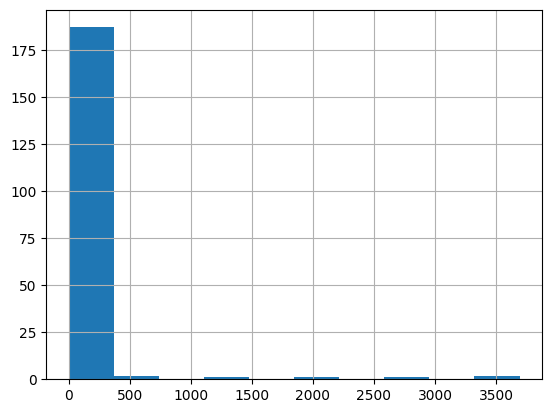

In [37]:
# есть signers с большим количеством видео, есть - с маленьким

duration.text_count.hist()
plt.show()

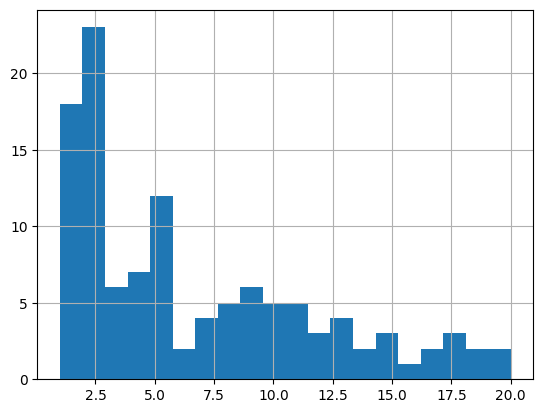

In [36]:
# но перекос не катастрофический

duration.text_count[duration.text_count <= 20].hist(bins=20)
plt.show()